# Import All Packages

In [1]:
import numpy as np
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal
from multiprocessing import Process, Manager

import sys
import numpy as np
import scipy.sparse as sp
from scipy.stats import poisson
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage import gaussian_filter

In [2]:
import Quagga
from Quagga import load_HiC

def strata2horizontal(strata):
    """
    From strata loaded from load_HiC(), construct the matrix for finding horizontal stripes.
    Assuming the full contact map is N * N and the first p strata are loaded in memory,
    for the k-th row, we pick up the p-pixel slice start from the matrix diagonal (i.e., the k-th element of the row),
    which is row[k: k + p].
    The result is a N * p matrix.

    Parameters
    ----------
    strata: list of np.array (1D)
        Loaded Hi-C strata

    Returns
    ----------
    hmat: np.array (2D)
        The N * p matrix for finding horizontal stripes

    """
    hmat = np.zeros((len(strata[0]), len(strata)))
    for i in range(len(strata)):
        hmat[:len(strata[i]), i] = strata[i]
    return hmat



def strata2vertical(strata):
    """
    From strata loaded from load_HiC(), construct the matrix for finding vertical stripes.
    Assuming the full contact map is N * N and the first p strata are loaded in memory,
    for the k-th column, we pick up the p-pixel slice start from the matrix diagonal (i.e., the k-th element of the column),
    which is column[k: k + p].
    The result is a N * p matrix.

    Parameters
    ----------
    strata: list of np.array (1D)
        Loaded Hi-C strata

    Returns
    ----------
    hmat: np.array (2D)
        The N * p matrix for finding vertical stripes

    """
    vmat = np.zeros((len(strata[0]), len(strata)))
    for i in range(len(strata)):
        vmat[i:, i] = strata[i]
    return vmat

# Load original GM12878 and DownSampled GM12878 data

In [3]:
HPATH = "/nfs/turbo/umms-drjieliu/proj/4dn/data/bulkHiC/GM12878/GM12878.hic"
# REMOVED = "/home/spmoran/temp_smoran/Fan_StripeCaller/V14/StripeCaller/Quagga/example/removed_regions.bed"
REF = "hg38"

In [4]:
strata, norm_factors = load_HiC.load_HiC(
    file=HPATH, 
    ref_genome=REF, format="hic",
    chromosome="chr1", resolution=5000, norm="KR",
    max_distance=2000000 + 200000
)

In [5]:
DPATH = '/nfs/turbo/umms-drjieliu/proj/4dn/data/bulkHiC/GM12878/raw/biorep1/biorep1.hic'

strataDS, norm_factorsDS = load_HiC.load_HiC(
    file=DPATH, 
    ref_genome=REF, format="hic",
    chromosome="chr1", resolution=5000, norm="KR",
    max_distance=2000000 + 200000
)

In [6]:
def extract_region_compare(strata1, strata2, start, end, resolution):
    st, ed = start // resolution, end // resolution
    length = ed - st
    mat1, mat2 = np.zeros((length, length)), np.zeros((length, length))
    
    # mat1: Upper tri
    for i, strata in enumerate(strata1):
        for j in range(length - i):
            mat1[j, j + i] = strata[st + j]
    
    # mat2: Lower tri
    for i, strata in enumerate(strata2):
        for j in range(length - i):
            mat2[j + i, j] = strata[st + j]
    
    # normalize the two tris
    factor = np.sum(mat1) / np.sum(mat2)
    mat1 = mat1 / factor
    
    mat = mat1 + mat2
    for i in range(length):
        mat[i, i] = mat[i, i] / 2
        
    return mat

### chr1:54-58 Mb. top right: original; bottom left: downsampled

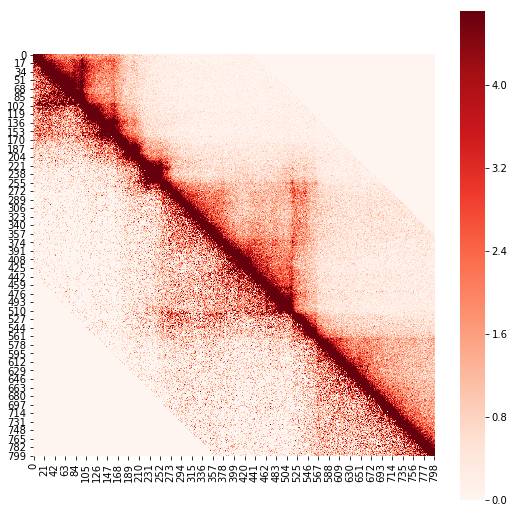

In [7]:
mat_combined = extract_region_compare(strata, strataDS, 54000000, 58000000, 5000)

plt.figure(figsize=(9, 9))
sns.heatmap(mat_combined, square=True, cmap='Reds', vmax=np.quantile(mat_combined, 0.95), vmin=0)
plt.show()

### Identify candidate peaks and widths

In [8]:
def get_stripe_and_widths_new(mat, nstrata_gap=400, nstrata_blank=10, sigma=12., rel_height=0.3, max_width=5):
    """
    From the sparse contact map, generate candidate vertical / horizontal stripes.

    Parameters
    ----------
    mat: np.array
        Contact matrix from "strata2horizontal()" or "strata2vertical()"

    nstrata_gap: int
        Max distance from the diagonal to calculate candidate peaks

    nstrata_blank: int
        Number of strata near the diagonal to blank out to calculate candidate peaks

    sigma: float
        Gaussian filter std

    rel_height: float
        Relative peak height for width calling

    Returns
    ----------
    peaks: dict
        Peak locations and peak widths

    """
    mat_sum = np.sum(mat[:, nstrata_blank:nstrata_gap], axis=1)
    s_filtered = gaussian_filter1d(mat_sum, sigma=sigma)
    s_max = signal.argrelmax(s_filtered)[0]
    s_widths = signal.peak_widths(s_filtered, peaks=s_max, rel_height=rel_height)[0]
    s_widths[s_widths > max_width] = max_width
    return mat_sum, s_filtered, {i: j for (i, j) in zip(s_max, s_widths)}


def vis_sum_and_peaks(signals, peaks, start, end, resolution):
    st, ed = start // resolution, end // resolution
    length = ed - st
    peaks = {k: peaks[k] for k in peaks if st <= k <= ed}
    
    plt.figure(figsize=(9, 4))
    for i, signal in enumerate(signals):
        plt.plot(np.arange(length), signal[st:ed])
    
    width = np.zeros((length,))
    for k in peaks:
        plt.axvline(k - st, color='red')
        w = int(round(peaks[k]))
        peak_st, peak_ed = max(0, k - st - w // 2), min(length, k - st + w // 2 + 1)
        # print(peak_st, peak_ed, k, st, signals[0][k - st])
        width[peak_st: peak_ed] = signals[0][k]
    
    plt.fill_between(np.arange(length), 0, width, alpha=0.3, color='gray')
    plt.show()
    plt.close()

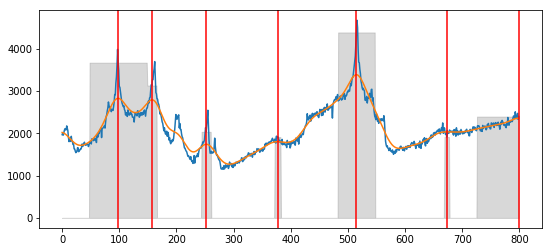

98 10898 100.65523090285387
157 10957 17.341957033038852
252 11052 16.116978699943502
377 11177 10.42783640833295
515 11315 63.651221046731735
673 11473 9.203655196513864
799 11599 145.68097326017414


In [12]:
vmat = strata2vertical(strata)
mat_sum, s_filtered, peaks = get_stripe_and_widths_new(vmat, nstrata_gap=400, nstrata_blank=10, sigma=12., rel_height=0.3, max_width=9999)

vis_sum_and_peaks([mat_sum, s_filtered], peaks, 54000000, 58000000, 5000)

for peak in peaks:
    if 54000000 // 5000 < peak < 58000000 // 5000:
        print(peak - 54000000 // 5000, peak, peaks[peak])

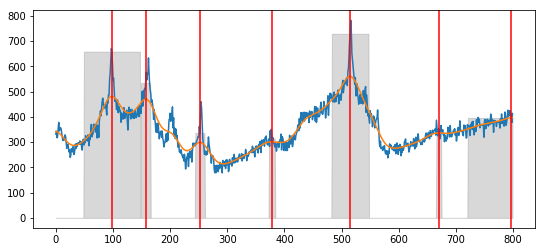

98 10898 99.1788476674974
157 10957 17.485023558514513
252 11052 16.087323110476063
378 11178 10.357153772089077
515 11315 64.03915609801697
670 11470 8.654334341264985
796 11596 151.44416287536296


In [14]:
vmatDS = strata2vertical(strataDS)
mat_sumDS, s_filteredDS, peaksDS = get_stripe_and_widths_new(vmatDS, nstrata_gap=400, nstrata_blank=10, sigma=12., rel_height=0.3, max_width=9999)

vis_sum_and_peaks([mat_sumDS, s_filteredDS], peaksDS, 54000000, 58000000, 5000)

for peak in peaksDS:
    if 54000000 // 5000 < peak < 58000000 // 5000:
        print(peak - 54000000 // 5000, peak, peaksDS[peak])

### We will focus on the peak at x=515 (real coordinate: 515 * 5K + 54 Mb)

# Calculate enrichment score for each pixel on the candidate stripe at x=515

In [16]:
from AVL_tree import AVLTree

def subsetNpMatrix(matrix, row_bounds, column_bounds):
    """
    Obtain the correct slice of a matrix considering x and y boundaries

    Parameters
    ----------
    matrix: np.array
        The original matrix

    row_bounds: tuple
        The upper and lower bounds for row indices

    column_bounds: tuple
        The upper and lower bounds for column indices

    Returns
    ----------
    subset: np.array
        The sub-matrix after slicing
    """
    rows = np.array([x for x in range(row_bounds[0], row_bounds[1]) if 0 <= int(x) < matrix.shape[0]])
    cols = np.array([y for y in range(column_bounds[0], column_bounds[1]) if 0 <= int(y) < matrix.shape[1]])
    if len(rows)==0 or len(cols)==0:
        return np.empty(0)
    subset = (matrix.ravel()[(cols + (rows * matrix.shape[1]).reshape((-1, 1))).ravel()]).reshape(rows.size, cols.size)
    return subset

In [17]:
def enrichment_score2(mat, idx, line_width, norm_factors, distance_range=(20, 40), window_size=10,
                      stats_test_log=({}, {})):
    """
    Calculate the enrichment score of a stripe given its location, width and the contact matrix

    Parameters:
    ----------
    mat: np.array (2D)
        Contact matrix generated with strata2horizontal() or strata2vertical()

    idx: int
        The location (index) of the candidate stripe

    line_width: int
        Stripe width (# of bins)

    norm_factors: np.array (1D)
        The vector of normalization factors of the contact map.

    distance_range: tuple
        The distance range (# of bins) for the diagonal for calculating the scores

    window_size: int
        Window size (# of bins)

    stats_test_log: tuple of dict
        Previous log for accelerating statistical tests


    Returns
    ----------
    new_mat: np.array (1D)
        The enrichment score of each pixel along the candidate stripe

    """
    _calculated_values, _poisson_stats = stats_test_log

    half = int(line_width // 2)
    x1, x2 = idx - half, idx - half + line_width
    if x1 == x2:
        x2 += 1

    new_mat = np.zeros((distance_range[1] - distance_range[0],))
    for j in range(distance_range[0], distance_range[1]):
        y = j - distance_range[0]
        _min_temp = subsetNpMatrix(mat, (x1, x2), (j - window_size - half, j + window_size + half + 1))
        line_min = np.median([_min_temp])
        # print(_min_temp, line_min)
        _inner_neighbor = subsetNpMatrix(mat, (idx - half - window_size, x1),
                                         (j - window_size - half, j + window_size + half + 1))
        _outer_neighbor = subsetNpMatrix(mat, (x2 + 1, idx + half + window_size + 1),
                                         (j - window_size - half, j + window_size + half + 1))

        if _outer_neighbor.size == 0 or _inner_neighbor.size == 0:
            continue
            
        neighbor_mean = max(np.mean(_inner_neighbor), np.mean(_outer_neighbor))

        # There should be a lower bound for the expected value,
        # otherwise situations like (exp=0.01 and obs=0.02) would also be significant
        # Currently we can set this to 0 until KR norm factors can be loaded
        lower_b = 1 / norm_factors[idx]  # This should be (1 / KR_norm_factors) if we refer to JuiceTools HICCUPS
        _exp = max(neighbor_mean, lower_b)
        _obs = int(line_min)  # the same as floor function when line_min > 0

        # _calculated_values: store all calculated exp-obs pairs in dictionary, in which keys are obs since
        #     they are always integers. Each _calculated_values[obs] is a binary tree for quick searching,
        #     and each tree leaf is a exp value corresponding to the obs value. Since exp values are float,
        #     there is also an integer index attached for searching the exp-obs in dictionary _poisson_stats
        #     (float cannot be dict keys).
        # _poisson_stats: record all calculated result in a dict. It should be
        #     _poisson_stats[(_exp, _obs)] = -log10(p). But _exp is a float and cannot be a dict key, we give
        #     each _exp a unique index and use the index.
        # stats_log: record all p value calculation. Just for benchmarking. Delete this when publishing.

        # global _calculated_values, _poisson_stats  # , stats_log
        tolerance = 0.02

        # check if obs is a value calculated before
        if _obs in _calculated_values:
            # Find the nearest _exp values which were calculated before
            # One larger, one smaller
            (_upper, _lower) = _calculated_values[_obs].search(_exp)
            # If _upper is close enough to _exp, directly use the p value from (_upper-_obs) pair
            if _upper is not None and (_upper.key - _exp) < tolerance * _exp:
                _exp = _upper.key
                _exp_idx = _upper.val  # The integer index for _upper (float cannot be dict keys!)
                mlog_p_val = _poisson_stats[(_exp_idx, _obs)]
            else:
                # Else, calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
                _exp_idx = _calculated_values[_obs].insert(_exp)  # insert to the binary tree and return an index
                Poiss = poisson(_exp)
                p_val = 1 - Poiss.cdf(_obs)
                if 0 < p_val < 1:
                    mlog_p_val = - np.log10(p_val)
                else:  # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                    mlog_p_val = -1
                _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
                # stats_log.append([_exp, _obs, mlog_p_val])
        else:  # If _obs is not used before, generate a new binary tree _calculated_values[_obs]
            _calculated_values[_obs] = AVLTree()
            _exp_idx = _calculated_values[_obs].insert(_exp)
            # calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
            Poiss = poisson(_exp)
            p_val = 1 - Poiss.cdf(_obs)
            if 0 < p_val < 1:
                mlog_p_val = - np.log10(p_val)
            else:  # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                mlog_p_val = -1
            _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
            # stats_log.append([_exp, _obs, mlog_p_val])

        # Store enrichment score in new_mat
        new_mat[y] = mlog_p_val
    new_mat[new_mat < 0] = np.max(new_mat)  # Replace all "-1"s with the largest -log(p)

    return new_mat

### In the figure:
### upper - a region (101 pixels * 440 pixels) of vmat centered at the x=515 stripe
### lower - the -log(p value) for each pixel on the candidate stripe; the red line is the threshold (i.e., -log(0.15))

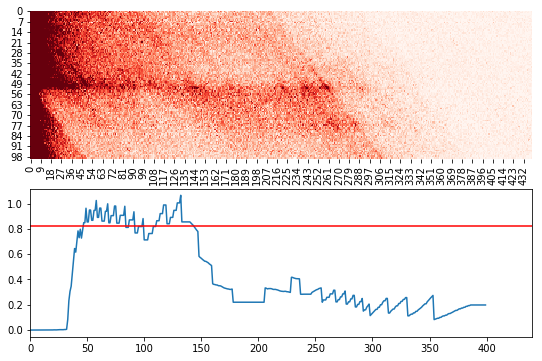

In [23]:
sub_mat = vmat[54000000 // 5000 + 515 - 50: 54000000 // 5000 + 515 + 50,:]
enrichment_score = enrichment_score2(vmat, 54000000 // 5000 + 515, 5, norm_factors,
                                     distance_range=(0, 400), window_size=30,
                                     stats_test_log=({}, {})
                                    )

plt.figure(figsize=(9, 6))
plt.subplot(211)
sns.heatmap(sub_mat, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.95), vmin=0, cbar=False)
plt.subplot(212)
plt.plot(np.arange(len(enrichment_score)), enrichment_score)
plt.axhline(-np.log10(0.15), c='red')
plt.xlim([0, sub_mat.shape[1]])
plt.show()

From the above figure, we could find that a "significant" stripe is from 40 to 140 (spanning range, distance from the diagonal)

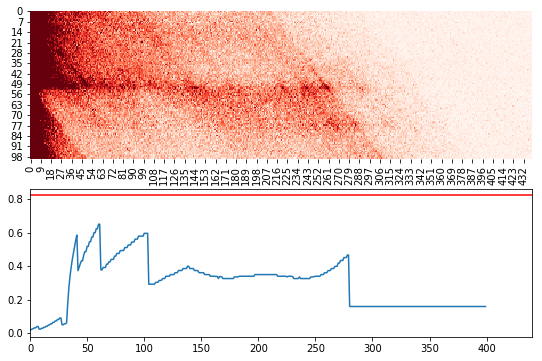

In [22]:
sub_matDS = vmat[54000000 // 5000 + 515 - 50: 54000000 // 5000 + 515 + 50,:]
enrichment_scoreDS = enrichment_score2(vmatDS, 54000000 // 5000 + 515, 5, norm_factorsDS,
                                     distance_range=(0, 400), window_size=30,
                                     stats_test_log=({}, {})
                                    )

plt.figure(figsize=(9, 6))
plt.subplot(211)
sns.heatmap(sub_matDS, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.95), vmin=0, cbar=False)
plt.subplot(212)
plt.plot(np.arange(len(enrichment_scoreDS)), enrichment_scoreDS)
plt.axhline(-np.log10(0.15), c='red')
plt.xlim([0, sub_matDS.shape[1]])
plt.show()

In the downsampled contact map, none of the pixels is significant (p < 0.15).

# Visualize certain pixels!

In [36]:
from matplotlib.patches import Rectangle


def pick_mat(vmat, location, norm_factors, distance_to_diag, line_width=5, window=30, vis_window=50, max_range=400):
    sub_mat = vmat[location - vis_window: location + vis_window + 1,:]
    enrichment_score = enrichment_score2(vmat, location, line_width, norm_factors,
                                         distance_range=(0, max_range), window_size=window,
                                         stats_test_log=({}, {})
                                        )

    plt.figure(figsize=(12, 9))
    plt.subplot(211)
    ax = sns.heatmap(sub_mat, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.95), vmin=0, cbar=False)
    half = int(line_width // 2)
    x1, x2 = location - half, location - half + line_width
    y1, y2 = distance_to_diag - window - half, distance_to_diag + window + half + 1
    _min_temp = subsetNpMatrix(vmat, (x1, x2), (y1, y2))
    line_min = np.median([_min_temp])
    x, y = distance_to_diag - window - half, vis_window - half
    width, height = 2 * window + line_width, line_width
    
    rect = Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.annotate(str(line_min)[:4], (x+2, y+4))
    
    
    # print(_min_temp, line_min)
    _inner_neighbor = subsetNpMatrix(vmat, (location - half - window, x1),
                                    (distance_to_diag - window - half, distance_to_diag + window + half + 1))
    _outer_neighbor = subsetNpMatrix(vmat, (x2 + 1, location + half + window + 1),
                                    (distance_to_diag - window - half, distance_to_diag + window + half + 1))
    
    x, y = distance_to_diag - window - half, vis_window - half - window
    width, height = 2 * window + line_width, window
    rect = Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.annotate(str(np.mean(_inner_neighbor))[:4], (x+2, y+4))
    
    x, y = distance_to_diag - window - half, vis_window + half + 1
    rect = Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.annotate(str(np.mean(_outer_neighbor))[:4], (x+2, y+height))
    
    plt.subplot(212)
    plt.plot(np.arange(len(enrichment_score)), enrichment_score)
    plt.axhline(-np.log10(0.15), c='red')
    plt.axvline(distance_to_diag, c='black', alpha=0.5)
    plt.xlim([0, sub_mat.shape[1]])
    plt.show()

### When we visualize the pixel which is 130 pixels from the diagonal:
### upper - vmat + center region and inner/outer neighbors (which should have been named upper and lower neighbors) + their mean value
### lower - the gray line is the calculated -log(p value) correspond to the center region in the upper sub-figure

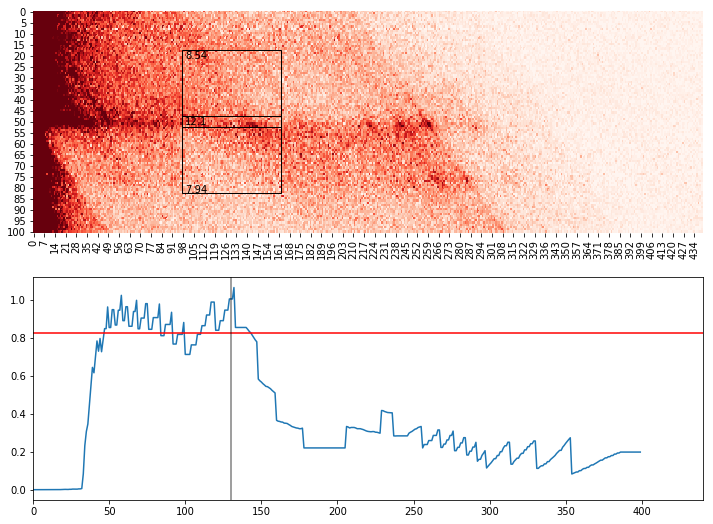

In [37]:
pick_mat(vmat, 54000000 // 5000 + 515, norm_factors, 130)

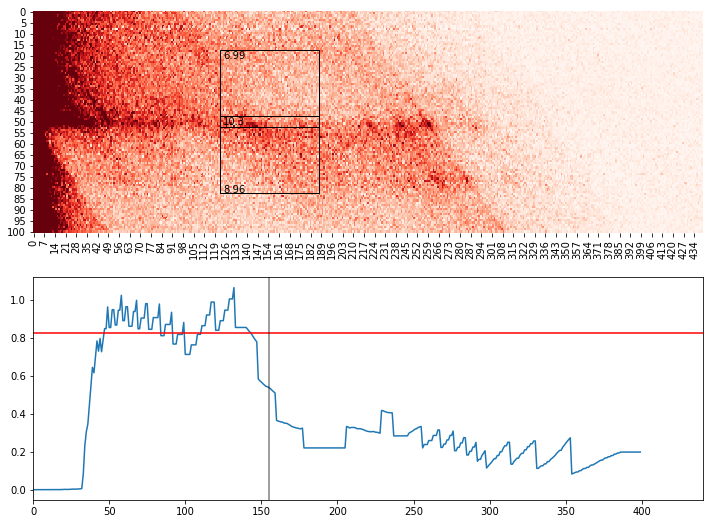

In [38]:
pick_mat(vmat, 54000000//5000 + 515, norm_factors, 155)

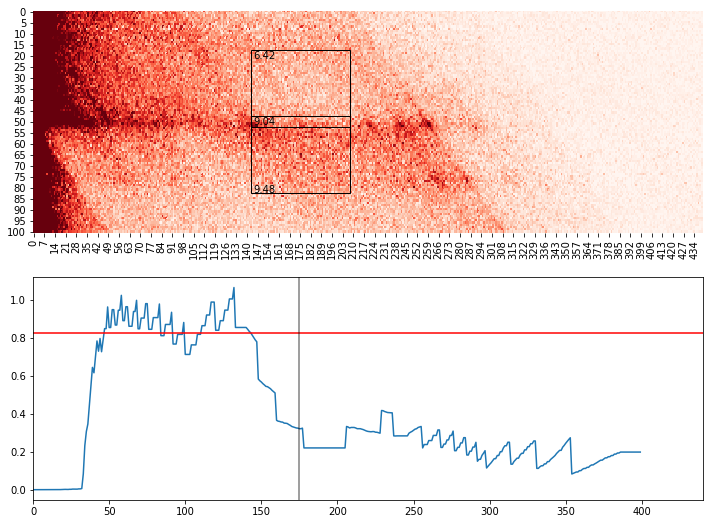

In [39]:
pick_mat(vmat, 54000000//5000 + 515, norm_factors, 175)

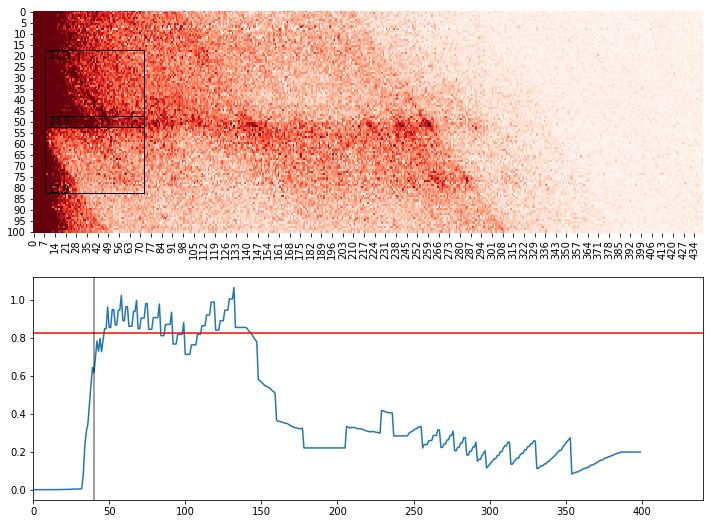

In [40]:
pick_mat(vmat, 54000000//5000 + 515, norm_factors, 40)

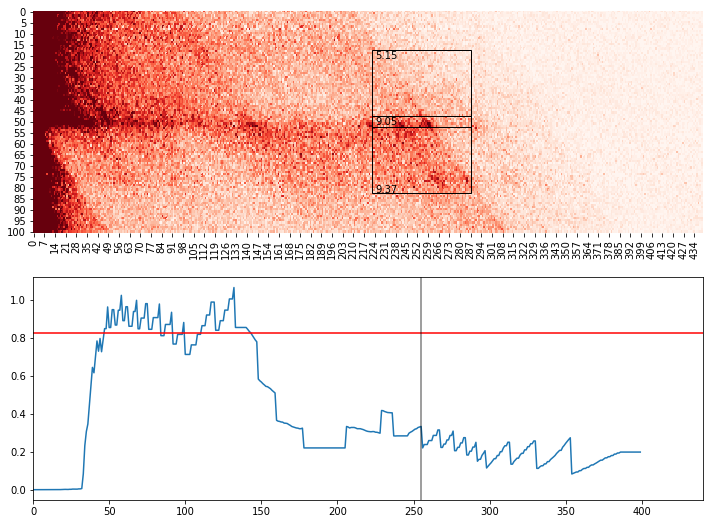

In [41]:
pick_mat(vmat, 54000000//5000 + 515, norm_factors, 255)

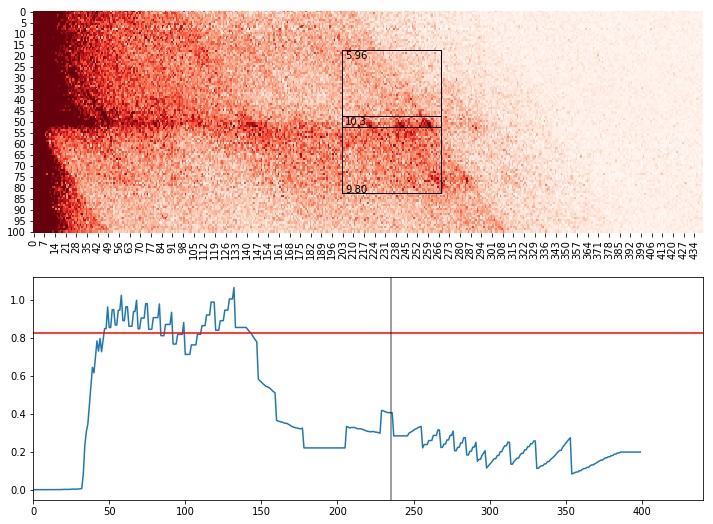

In [42]:
pick_mat(vmat, 54000000//5000 + 515, norm_factors, 235)

### From the above figures, we can probably say most of pixels on the stripe do get a significant small p value.

### However, in the downsampled contact map, mean(center_region) and mean(neighbors) are both small values, which results in no significant pixels identified!!!

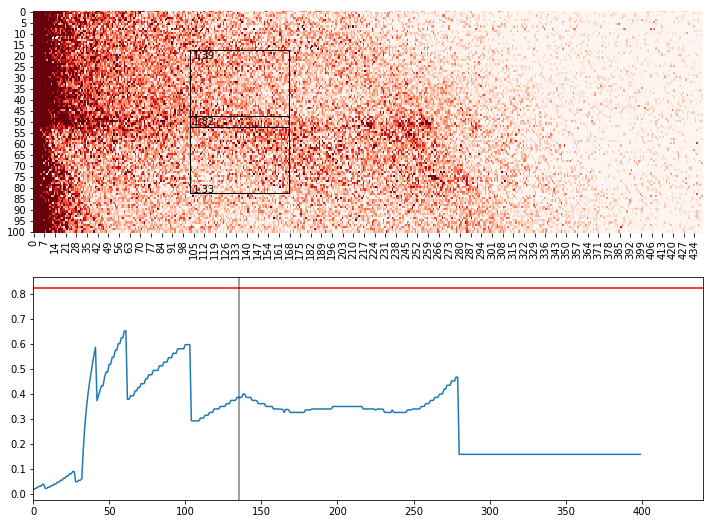

In [45]:
pick_mat(vmatDS, 54000000//5000 + 515, norm_factorsDS, 135)

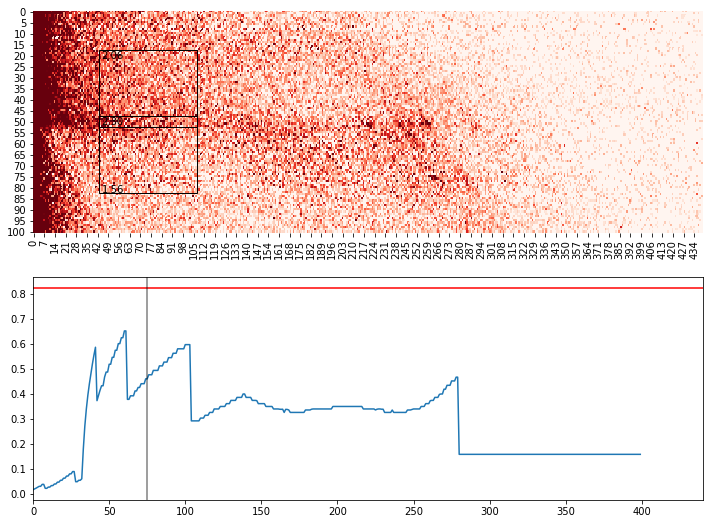

In [44]:
pick_mat(vmatDS, 54000000//5000 + 515, norm_factorsDS, 75)

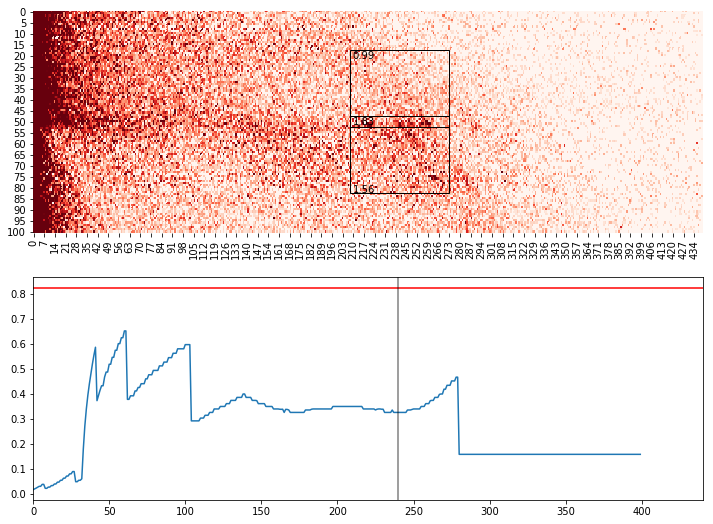

In [46]:
pick_mat(vmatDS, 54000000//5000 + 515, norm_factorsDS, 240)

### Smaller values in Poisson:

In [47]:
Poiss = poisson(2)
p_val = 1 - Poiss.cdf(3)
print(p_val)

0.14287653950145296


In [48]:
Poiss = poisson(4)
p_val = 1 - Poiss.cdf(6)
print(p_val)

0.11067397840257365


In [49]:
Poiss = poisson(10)
p_val = 1 - Poiss.cdf(15)
print(p_val)

0.04874040330397866
